# 🐶 End-to-end Multi-Class Dog Breed Classification

This notebook builds an end-to-end multiclass image classifier using Tensorflow 2 and Tensorflow Hub.

## 1. Problem

Identifying the breed of a dog given an image of a dog.

## 2. Data

The data comes from Kaggle's Dog Breed Identification competition: [Kaggle](https://www.kaggle.com/c/dog-breed-identification/).

## 3. Evaluation

The evaluation is a file with prediction probabilities forEach dog breed for each test image: [Evaluation](https://www.kaggle.com/c/dog-breed-identification/overview/evaluation).


## 4. Features

Some information about the data:
* images = unstructured data -> it's probably best to use deep learning/transfer learning
* 120 breeds of dogs (multi-class)
* there 10,000+ images in the training set (with labels)
* there are 10,000+ images in the testing set (no labels)



## 0. Get Workspace Ready

* import Tensorflow 2.x
* import Tensorflow Hub
* make sure we're using a GPU


In [0]:
# import Tensorflow TF 2.0
try:
  # %tensorflow_version only exists in Colab
  %tensorflow_version 2.x
except Exception:
  pass

In [5]:
# import necessary tools
import tensorflow as tf
import tensorflow_hub as hub
print('TF version:', tf.__version__)
print('TF Hub version:', hub.__version__)

# Check for GPU available
print('GPU', 'available (Yeah!)' if tf.config.list_physical_devices('GPU') else 'not avaiable...')

TF version: 2.1.0
TF Hub version: 0.7.0
GPU available (Yeah!)


### Getting Data Ready

Transform input data into numerical format (Tensors).

Let's start by accessing our data and checking out labels

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

labels_csv = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/dog-breed/labels.csv')
labels_csv.describe()

id               breed
count                              10222               10222
unique                             10222                 120
top     db953c4fb2ef6767dd6c817574b4e447  scottish_deerhound
freq                                   1                 126

In [7]:
# How images are there for each breed?
labels_csv['breed'].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
brabancon_griffon        67
golden_retriever         67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

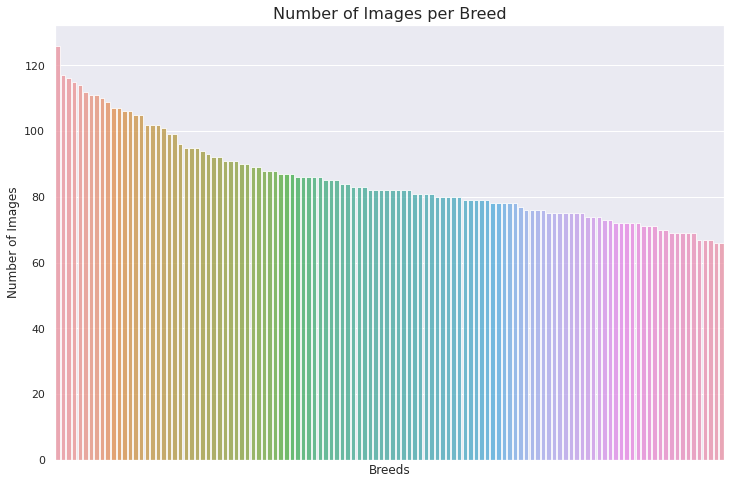

In [8]:
# Plotting a bar chart for the target values
breed_count = labels_csv['breed'].value_counts()
plt.figure(figsize=(12,8))
sns.barplot(breed_count.index, breed_count.values,
            order=breed_count.index,
            alpha=0.8)
plt.title('Number of Images per Breed', fontdict={'fontsize': 16})
plt.ylabel('Number of Images')
plt.xlabel('Breeds')
plt.xticks([]);

In [9]:
# Average number of images per breed
breed_count.median()

82.0

In [10]:
# Let's view an image
from IPython.display import Image
Image('/content/drive/My Drive/Colab Notebooks/data/dog-breed/train/0a0c223352985ec154fd604d7ddceabd.jpg')

### Getting images and their labels

Let's get a list of all image file pathnames.

In [11]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [12]:
# Create pathnames from image IDs
fpath = '/content/drive/My Drive/Colab Notebooks/data/dog-breed/train/'
filenames = [fpath + fname + '.jpg' for fname in labels_csv['id']]
filenames[:5]

['/content/drive/My Drive/Colab Notebooks/data/dog-breed/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/My Drive/Colab Notebooks/data/dog-breed/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/My Drive/Colab Notebooks/data/dog-breed/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/My Drive/Colab Notebooks/data/dog-breed/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/My Drive/Colab Notebooks/data/dog-breed/train/0021f9ceb3235effd7fcde7f7538ed62.jpg']

In [13]:
# Check if number of filenames matches number of actual image files
import os
if len(os.listdir(fpath)) == len(filenames):
  print('Filenames match actual amount of files. Proceed.')
else:
  print(f'Error: actual num of files: {len(os.listdir(fpath))} - labels.csv: {len(filenames)}')

Filenames match actual amount of files. Proceed.


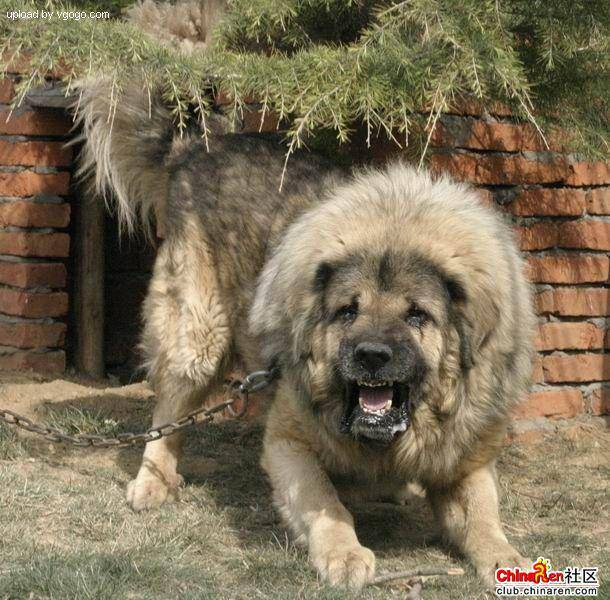

In [14]:
# Another check
Image(filenames[9000])

The training image filepaths are now accessible as a Python list.
Now prepare the labels.

In [15]:
labels = np.array(labels_csv['breed'])
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [16]:
len(labels)

10222

In [17]:
# Check if number of labels matches number of filenames
len(filenames) == len(labels)

True

In [0]:
unique_breeds = np.unique(labels)

In [19]:
# Check number of unique breeds (should be 120)
len(unique_breeds) == 120

True

**We need to encode the labels**. The labels are categorical data with nominal values (no intrinsic order). See [Categorical Variables](https://github.com/sophiabrandt/udemy-feature-engineering/blob/master/notebooks/original-course-notebooks/Section-02-Types-of-Variables/02.2-Categorical-Variables.ipynb).

In [20]:
# Use LabelBinarizer to encode labels
from sklearn.preprocessing import LabelBinarizer

# Create one-hot encoder
one_hot = LabelBinarizer()

# One-hot encode labels
encoded_labels = one_hot.fit_transform(labels)
encoded_labels[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### Creating our own validation set

Since the dataset from Kaggle doesn't come with a validation set, we're going to create our own.

In [0]:
# Setup X & y variables
X = filenames
y = encoded_labels

We're going to start off experimentind with ~1000 images for a fast feedback loop and increase as needed.

In [0]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 # @param {type: 'slider', min:1000, max: 10222}

In [0]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split data into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=33)

In [24]:
len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [25]:
# Check the training data
X_train[:2], y_train[:2]

(['/content/drive/My Drive/Colab Notebooks/data/dog-breed/train/151f312fa21196af9b53b0e77baa3a06.jpg',
  '/content/drive/My Drive/Colab Notebooks/data/dog-breed/train/164a194e9bf8819523235879eb0c2698.jpg'],
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
   

## Preprocessing Images (Turning Images into Tensors)

We'll write a preprocess function that does the following:

1. Take an image filepath as input (string)
2. Use Tensorflow to read the file and save it to variable `image`
3. Turn `image` (a jpg) into Tensors
4. Normalize image (convert color channel values from 0-255 to 0-1)
5. Resize `image` to be a shape of (224, 224)
6. Return the modified `image`

In [26]:
# Prior step: turn image into Numpy array
from matplotlib.pyplot import imread
image = imread(filenames[3])
image.shape

(344, 400, 3)

In [27]:
image

array([[[ 71,  67,  66],
        [ 97,  93,  92],
        [ 84,  83,  81],
        ...,
        [ 67,  69,  56],
        [ 56,  62,  50],
        [ 49,  57,  46]],

       [[ 57,  53,  52],
        [ 94,  90,  89],
        [ 92,  91,  89],
        ...,
        [ 46,  48,  35],
        [ 40,  46,  34],
        [ 41,  49,  38]],

       [[ 63,  59,  58],
        [ 99,  95,  94],
        [ 89,  88,  86],
        ...,
        [ 42,  42,  30],
        [ 45,  48,  37],
        [ 58,  64,  52]],

       ...,

       [[104,  88,  75],
        [136, 120, 107],
        [147, 134, 118],
        ...,
        [102,  80,  69],
        [113,  88,  84],
        [117,  89,  88]],

       [[121, 105,  92],
        [ 80,  64,  51],
        [134, 121, 105],
        ...,
        [150, 128, 117],
        [ 93,  68,  64],
        [122,  94,  93]],

       [[114,  98,  85],
        [100,  84,  71],
        [117, 104,  88],
        ...,
        [112,  90,  79],
        [105,  80,  76],
        [121,  93,  92]]

In [28]:
tf.constant(image)

<tf.Tensor: shape=(344, 400, 3), dtype=uint8, numpy=
array([[[ 71,  67,  66],
        [ 97,  93,  92],
        [ 84,  83,  81],
        ...,
        [ 67,  69,  56],
        [ 56,  62,  50],
        [ 49,  57,  46]],

       [[ 57,  53,  52],
        [ 94,  90,  89],
        [ 92,  91,  89],
        ...,
        [ 46,  48,  35],
        [ 40,  46,  34],
        [ 41,  49,  38]],

       [[ 63,  59,  58],
        [ 99,  95,  94],
        [ 89,  88,  86],
        ...,
        [ 42,  42,  30],
        [ 45,  48,  37],
        [ 58,  64,  52]],

       ...,

       [[104,  88,  75],
        [136, 120, 107],
        [147, 134, 118],
        ...,
        [102,  80,  69],
        [113,  88,  84],
        [117,  89,  88]],

       [[121, 105,  92],
        [ 80,  64,  51],
        [134, 121, 105],
        ...,
        [150, 128, 117],
        [ 93,  68,  64],
        [122,  94,  93]],

       [[114,  98,  85],
        [100,  84,  71],
        [117, 104,  88],
        ...,
        [112,  90,  7

In [0]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path (string) and turns it into a Tensor.
  """
  # Read the image file
  image = tf.io.read_file(image_path)
  # Turn the jpg image into numerical Tensor with 3 color channels
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert  color channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, dtype=tf.float32)
  # Resize image to (224, 244)
  image = tf.image.resize(image, size=[img_size, img_size])

  return image

## Turning data into batches

Why turn our data into batches?

Large amounts of data might not fit into memory.

We need to limit our images to batch-size. We start with 32 images per run.

To use Tensorflow effectively, the data must be in the form of Tensor tuples.


In [0]:
# Create a function that returns a tuple (image, label)
def to_tf_tuple(image_path, label):
  """
  Takes an image filepath (string) and associated label (numpy array),
  preproccesses the image,
  and returns a tuple of (image, label):
  """
  image = process_image(image_path)
  return image, label

In [31]:
to_tf_tuple(X_train[0], y_train[0])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.08596846, 0.20336589, 0.09521668],
         [0.09337845, 0.20306952, 0.07443587],
         [0.13824561, 0.24353477, 0.07336466],
         ...,
         [0.08181531, 0.09046388, 0.00652503],
         [0.09135146, 0.08634454, 0.00427965],
         [0.10013993, 0.08336842, 0.        ]],
 
        [[0.07033923, 0.17828742, 0.05190045],
         [0.08866125, 0.19302629, 0.04855849],
         [0.1428026 , 0.24278714, 0.06452472],
         ...,
         [0.06947943, 0.07812799, 0.00118656],
         [0.07662807, 0.07082167, 0.        ],
         [0.08103207, 0.07014084, 0.        ]],
 
        [[0.10131304, 0.20132539, 0.04067393],
         [0.12414217, 0.22142656, 0.05334181],
         [0.1863022 , 0.27051088, 0.08806945],
         ...,
         [0.06942457, 0.07600919, 0.00587514],
         [0.07137185, 0.07361695, 0.00481443],
         [0.0757528 , 0.07361695, 0.00481443]],
 
        ...,
 
        [[0.2552524 , 0.14937003

Now let's make a function to turn all our data into batches of Tensor tuples.

In [0]:
# Define batch size
BATCH_SIZE = 32

# Helper function to create a Tensor dataset
def to_tf_dataset(X, y=None):
  """
  Returns a Tensor Dataset from Tensor slices.
  """
  dataset = tf.data.Dataset.from_tensor_slices((X, y))
  return dataset

# Create a function to turn data into btches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of size `batch_size` out of image (X) and
  one-hot encoded label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle validation data.
  Also accepts test data as input (no labels).
  """
  # For test data, batch data without labels
  if test_data:
    print('Creating test data batches ...')
    data = to_tf_dataset(tf.constant(X)) # only file paths, no labels
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # For validation dataset, batch data, with labels, without shuffling
  elif valid_data:
    print('Creating validation data batches ...')
    data = to_tf_dataset(tf.constant(X),  # file paths
                          tf.constant(y)) # labels 
    data_batch = data.map(to_tf_tuple).batch(BATCH_SIZE)
    return data_batch

  # For training data, shuffle and batch, with labels
  else:
    print('Creating training data batches...')
    # Turn filepaths and labels into Tensors
    data = to_tf_dataset(tf.constant(X),
                          tf.constant(y))
    # Shuffling pathnames and labels
    data = data.shuffle(buffer_size=len(X))
    # Create (image, label) tuples
    data = data.map(to_tf_tuple)
    # Turn training data into batches
    data_batch = data.batch(BATCH_SIZE)

    return data_batch                                                   

In [33]:
# Creating and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches ...


In [34]:
# Check out the different attributes of the data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.int64, name=None)))

## Visualizing Data Batches

The data is now in batches. But they are hard to understand. Let's visualize them!

In [0]:
# Create a funtion for viewing images in a data batch

def show_25_images(images, labels):
  """
  Displays a plot of 25 images
  and their labels from a data batch.
  """
  plt.figure(figsize=(10,10))
  # Loop until 25
  for i in range(25):
    # Create subplots
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis('off')

In [0]:
train_images, train_labels = next(train_data.as_numpy_iterator())

In [37]:
train_data, train_labels

(<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.int64)>,
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]))

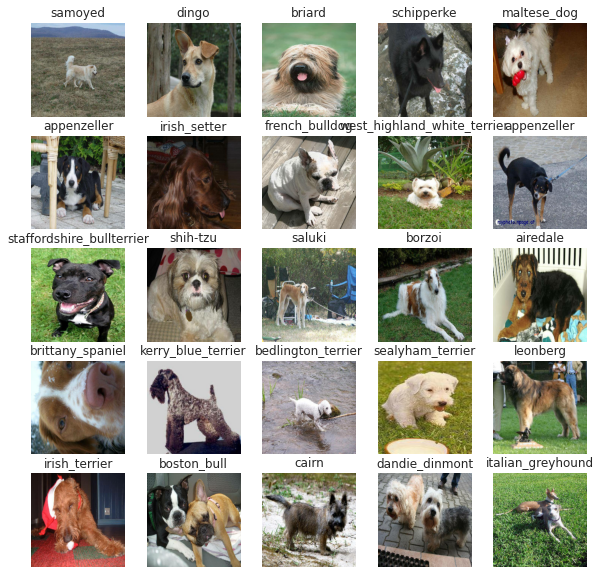

In [38]:
# Let's visualize the data in a training batch
show_25_images(train_images, train_labels)

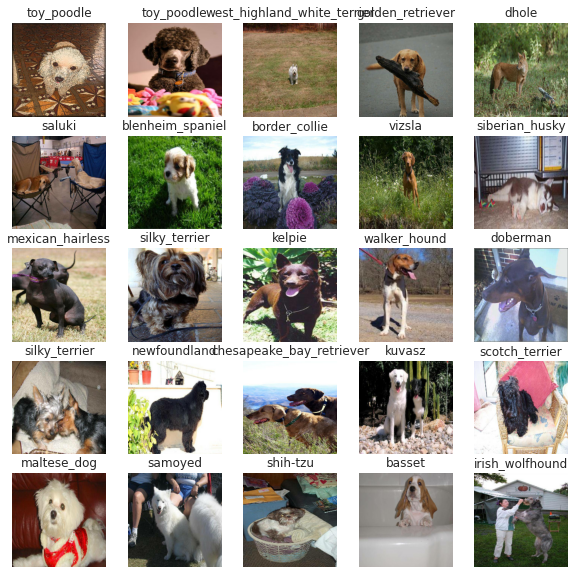

In [39]:
# Visualize data in validation batch
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a Model

Before we build a model, there are a few things we need to define:

* The _input_ shape (images shape, in the form of Tensors)
* The _output_ shape (image labels, in the form of Tensors)
* The URL of the Tensorflow Hub model we want to use.

In [0]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color channels

# Setup the output shape
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from Tensorflow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

Let's put everything together into a Keras deep learning model.

We create a function which:

* takes the input shape, output shape and the model as parameters
* defines the layers in a Keras model in sequential fashion
* compiles the model (it should be evaluated and improved)
* builds the model (tells the model the input shape)
* returns the model

For further information, see [Keras overview](https://www.tensorflow.org/guide/keras/overview).

In [0]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE,
                 output_shape=OUTPUT_SHAPE,
                 model_url=MODEL_URL):
  """
  Creates a Keras model from Tensorflow Hub.
  """
  print('Building model with: ', MODEL_URL)
  
  # Setup the model
  model = tf.keras.Sequential([
                               hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
                               tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                                                     activation='softmax') # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=['accuracy']
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model


In [42]:
model = create_model()
model.summary()

Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  5432713   
_________________________________________________________________
dense (Dense)                multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating callbacks

Callbacks are helper functions a model can use during training to save its progress, check its progress or stop training if the model stops improving.

We'll create two callbacks, one for **TensorBoard** (tracks the model's grogress), one for **early stopping** (prevents model from over-fitting).


### TensorBoard Callback

Three steps:

1. Load Tensorboard notebook extension
2. Create a Tensorboard callback which is able to save logs to a directory and pass it to the model's `fit()` function
3. Visualize model's training logs with `%tensorboard` magic function

In [0]:
# Load Tensorboard
%load_ext tensorboard

In [0]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing Tensorboard logs
  log_dir = os.path.join('drive/My Drive/Colab Notebooks/data/dog-breed/logs',
                         # Logs get tracked when we run an experiment
                         datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
  return tf.keras.callbacks.TensorBoard(log_dir=log_dir)

#### Early Stopping Callback

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

Early stopping hinders theModel from overfitting if a particular evaluation metric stops improving.

In [0]:
# Create early stopping callbck
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=3)

## Training a model (on subset of data)

Aim for fast feedback loop.



In [0]:
NUM_EPOCHS = 100 #@param {type:'slider', min:10, max:100}

In [47]:
# Check to make sure we're still running on a GPU
print('GPU', 'available (YES!)' if tf.config.list_physical_devices('GPU') else 'Oh No! GPU not avaiable!')

GPU available (YES!)


Let's create a function which trains a model.

* Create a model using `create_model()`
* Set a Tensorboard callback using `create_tensorboard_callback`
* Call `fit()` function on model passing it training data, validation data, num of epochs to train for (`NUM_EPOCHS`) and callback's we'd like to use
* return model

In [0]:
# Build a function to train and return a trained model
def train_model():
  """"
  Trains a given model and returns trained version.
  """
  # Create a model
  model = create_model()

  # Create new Tensorboard session for each trained model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it to the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  
  # Return the fitted model
  return model

In [73]:
# Fit the model to the data
model = train_model()

Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Train for 25 steps, validate for 7 steps
Epoch 1/100
25/25 [==============================] - 9s 365ms/step - loss: 4.5523 - accuracy: 0.1225 - val_loss: 3.0979 - val_accuracy: 0.3050
Epoch 2/100
25/25 [==============================] - 6s 222ms/step - loss: 1.6231 - accuracy: 0.6825 - val_loss: 1.9125 - val_accuracy: 0.5800
Epoch 3/100
25/25 [==============================] - 6s 225ms/step - loss: 0.5484 - accuracy: 0.9400 - val_loss: 1.5262 - val_accuracy: 0.6650
Epoch 4/100
25/25 [==============================] - 6s 221ms/step - loss: 0.2417 - accuracy: 0.9875 - val_loss: 1.3841 - val_accuracy: 0.6800
Epoch 5/100
25/25 [==============================] - 6s 220ms/step - loss: 0.1398 - accuracy: 0.9987 - val_loss: 1.3149 - val_accuracy: 0.6850
Epoch 6/100
25/25 [==============================] - 5s 218ms/step - loss: 0.0960 - accuracy: 1.0000 - val_loss: 1.2769 - val_accuracy: 0.7050
Epoch 7

**Note**: The model is overfitting because it's performing better on the training set than on the validation set.

Overfitting at the begin is good. It means the model is learning.

### Checking the Tensorboard logs

The TensorBoard magic function (`%tensorboard`) will access the logs directory we created earlien and visualize its contents.

In [74]:
%tensorboard --logdir 'drive/My Drive/Colab Notebooks/data/dog-breed/logs'

Reusing TensorBoard on port 6007 (pid 1768), started 0:01:32 ago. (Use '!kill 1768' to kill it.)

<IPython.core.display.Javascript object>

## Making and Evaulating Predictions Using a Trained Model

In [51]:
# Make predictions on validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)

7/7 [==============================] - 2s 217ms/step


In [52]:
predictions

array([[2.61058958e-05, 7.88721518e-05, 9.57385510e-06, ...,
        2.44334638e-06, 1.31971797e-06, 2.03789282e-03],
       [8.53201025e-04, 1.06166175e-04, 1.97413701e-05, ...,
        3.06159811e-04, 1.69949737e-04, 8.46794341e-03],
       [1.73339657e-02, 2.15870852e-04, 1.92792353e-03, ...,
        1.43481209e-03, 2.46995969e-05, 1.43991578e-02],
       ...,
       [3.00237571e-05, 7.44806457e-05, 6.21734885e-04, ...,
        1.14802213e-04, 1.90312194e-03, 2.35628730e-04],
       [6.32849293e-08, 1.22136174e-04, 2.06811819e-07, ...,
        1.54629175e-04, 1.47561695e-06, 1.88642855e-06],
       [1.60469222e-04, 2.53752514e-05, 4.18023374e-05, ...,
        5.10684622e-04, 4.74016473e-04, 4.35327274e-05]], dtype=float32)

In [53]:
predictions.shape

(200, 120)

In [54]:
# First prediction
index = 19
print(predictions[index])
print(f'Max value (probability of prediction): {np.max(predictions[index])}')
print(f'Sum: {np.sum(predictions[index])}')
print(f'Max index: {np.argmax(predictions[index])}')
print(f'Predicted label: {unique_breeds[np.argmax(predictions[index])]}')

[2.70423174e-01 2.66571483e-03 1.17975424e-05 3.88844707e-03
 1.33432231e-05 2.65700000e-05 5.12325059e-05 8.35088867e-05
 6.33805234e-04 1.16441952e-05 2.12343017e-04 6.29227143e-05
 6.67755085e-05 1.03895480e-04 1.41547166e-03 3.60442180e-04
 3.87797219e-04 2.78009772e-02 2.42324269e-04 1.93559026e-06
 9.65607092e-02 3.07416558e-05 4.02500184e-04 7.64228898e-05
 9.15345936e-06 3.69642425e-04 3.37183988e-03 1.64313005e-05
 1.01484429e-05 1.54605747e-04 1.39070748e-04 5.60885273e-05
 5.28046163e-03 5.35110894e-06 2.62275748e-02 5.50356890e-05
 1.76404574e-05 7.43426835e-06 1.34740461e-04 3.49246438e-05
 1.48652049e-04 1.51130871e-03 2.19774802e-06 8.45322720e-05
 6.82543684e-03 1.50626292e-05 6.23662199e-05 5.61062945e-04
 2.23580822e-02 2.53328122e-04 9.18506272e-03 5.18315246e-05
 5.81197310e-05 2.55234767e-07 2.34797201e-03 7.17218654e-06
 8.49762582e-04 2.37205633e-04 7.04677869e-03 6.58355234e-03
 1.35127652e-06 4.70463965e-06 1.27686246e-03 2.46593427e-05
 1.09209353e-02 1.672902

In [0]:
# Turn prediction probabilities into their respective labels
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

In [56]:
# Get a predicted label based on an array of prediction probabilites
preds_label = get_pred_label(predictions[20])
preds_label

'maltese_dog'

In [57]:
# How does val_data look like?
val_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.int64)>

The validation data is in a batch dataset, we have to unpack it to make predictions on the validation images and then compare those predictions on the validation labels.

In [0]:
# Create a function to unpack batch dataset (unbatch)

def unbatch_images(val_data):
  """
  Given a batched dataset of (image, label)
  returns a tuple containing the images and labels as lists.
  """
  images = []
  labels = []
  
  # loop
  for image, label in val_data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  
  return (images, labels)

In [0]:
val_images, val_labels = unbatch_images(val_data)


In [60]:
val_images[0]

array([[[1.12076558e-01, 1.15998127e-01, 9.24687088e-02],
        [2.76695371e-01, 2.64930665e-01, 2.45322824e-01],
        [2.73874313e-01, 2.48672992e-01, 2.34439805e-01],
        ...,
        [3.01527977e-01, 2.66015351e-01, 2.29486868e-01],
        [2.85314620e-01, 2.57863671e-01, 2.34159529e-01],
        [6.92723989e-01, 6.78359389e-01, 6.61307812e-01]],

       [[7.76547417e-02, 7.93340057e-02, 5.79288825e-02],
        [8.21383297e-02, 7.02993795e-02, 5.07286564e-02],
        [8.98056999e-02, 6.25105575e-02, 4.93242666e-02],
        ...,
        [1.89490855e-01, 1.51884213e-01, 1.14123404e-01],
        [8.21435228e-02, 5.46184443e-02, 2.43727956e-02],
        [5.63744307e-01, 5.49342811e-01, 5.29001951e-01]],

       [[9.60060507e-02, 9.20844823e-02, 7.68230632e-02],
        [1.12794168e-01, 1.00630313e-01, 8.16929713e-02],
        [1.24824993e-01, 9.71551836e-02, 8.42554122e-02],
        ...,
        [1.40956700e-01, 9.63665694e-02, 5.17764315e-02],
        [1.12020336e-01, 7.66

In [61]:
val_labels[0]

'toy_poodle'

In [62]:
# Get label for the prediction of the first image (index 0)
get_pred_label(predictions[0])

'toy_poodle'

In [63]:
# Get the true label for the first image (index 0)
get_pred_label(val_labels[0])

'affenpinscher'

Now we've got ways to get:

* prediction labels
* validation labels (truth labels)
* validation images

Let's make some functions to visualize these.

We'll create a function which:

* takes an arry of prediction probilities, an array of truth labels and an array of images and an integer
* convert the prediction probabilities to a predicted label
* plot the predicted label, its predicted probabilities and th target image on a single plot

In [0]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the prediction label
  pred_label = get_pred_label(pred_prob)

  # Plot image and & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the color of title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = 'green'
  else:
    color = 'red'

  # Change plot title to the the predicted, probabilitiy of prediction and truth label
  plt.title('{} {:2.0f}% {}'.format(pred_label,
                                     np.max(pred_prob)*100,
                                     true_label),
            color=color)

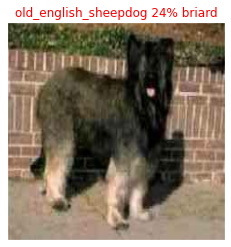

In [65]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=32)

Now we've got one function to visualize our models to top prediction,Let's make another to view the model's top 10 predictions.

This function will:

* take an input of prediciton probabilities array and a ground truth array and an integer
* find the prediction using `get_pred_label()`
* find the top 10:
    * prediction probabilities indexes
    * prediction probabilities values
    * prediction labels
* plot the top 10 prediction probability values and labels, coloring the true label green

In [0]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plot the top 10 highest prediction confidences along with th truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]

  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]

  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color='grey')
  plt.xticks(np.arange(len(top_10_pred_labels)),
                       labels=top_10_pred_labels,
                       rotation='vertical')
  
  # Change the color of the true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color('green')

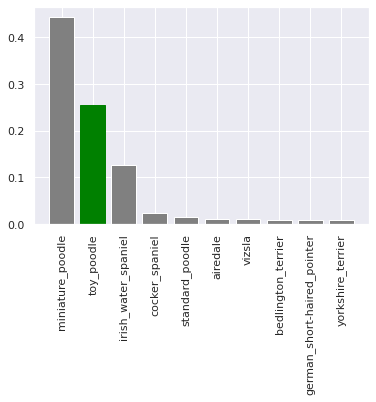

In [67]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels)

Now we've got some functions to help us visualize our predictionsAnd evaluate our model, we'll write a function to show a number of predicted image.

In [0]:
def plot_predictions(num_images=6, starting_image_index=1):
  """
  Shows images with prediction and a bar chart
  with the top 10 predictions for those images.

  num_images: number of images to show
  starting_image_index: index of the first image
  """
  num_rows = num_images / 2
  num_cols = 2
  
  plt.figure(figsize=(10*num_cols, 5*num_rows))
  
  # Plot each image
  for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    # Show image, prediction and truth label
    plot_pred(prediction_probabilities=predictions,
              labels=val_labels,
              images=val_images,
              n=i+starting_image_index)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    # Show bar plot with top 10 predictions
    plot_pred_conf(prediction_probabilities=predictions,
                   labels=val_labels,
                   n=i+starting_image_index)

  # Group plot, add horizontal padding
  plt.tight_layout(h_pad=1.0)
  plt.show()

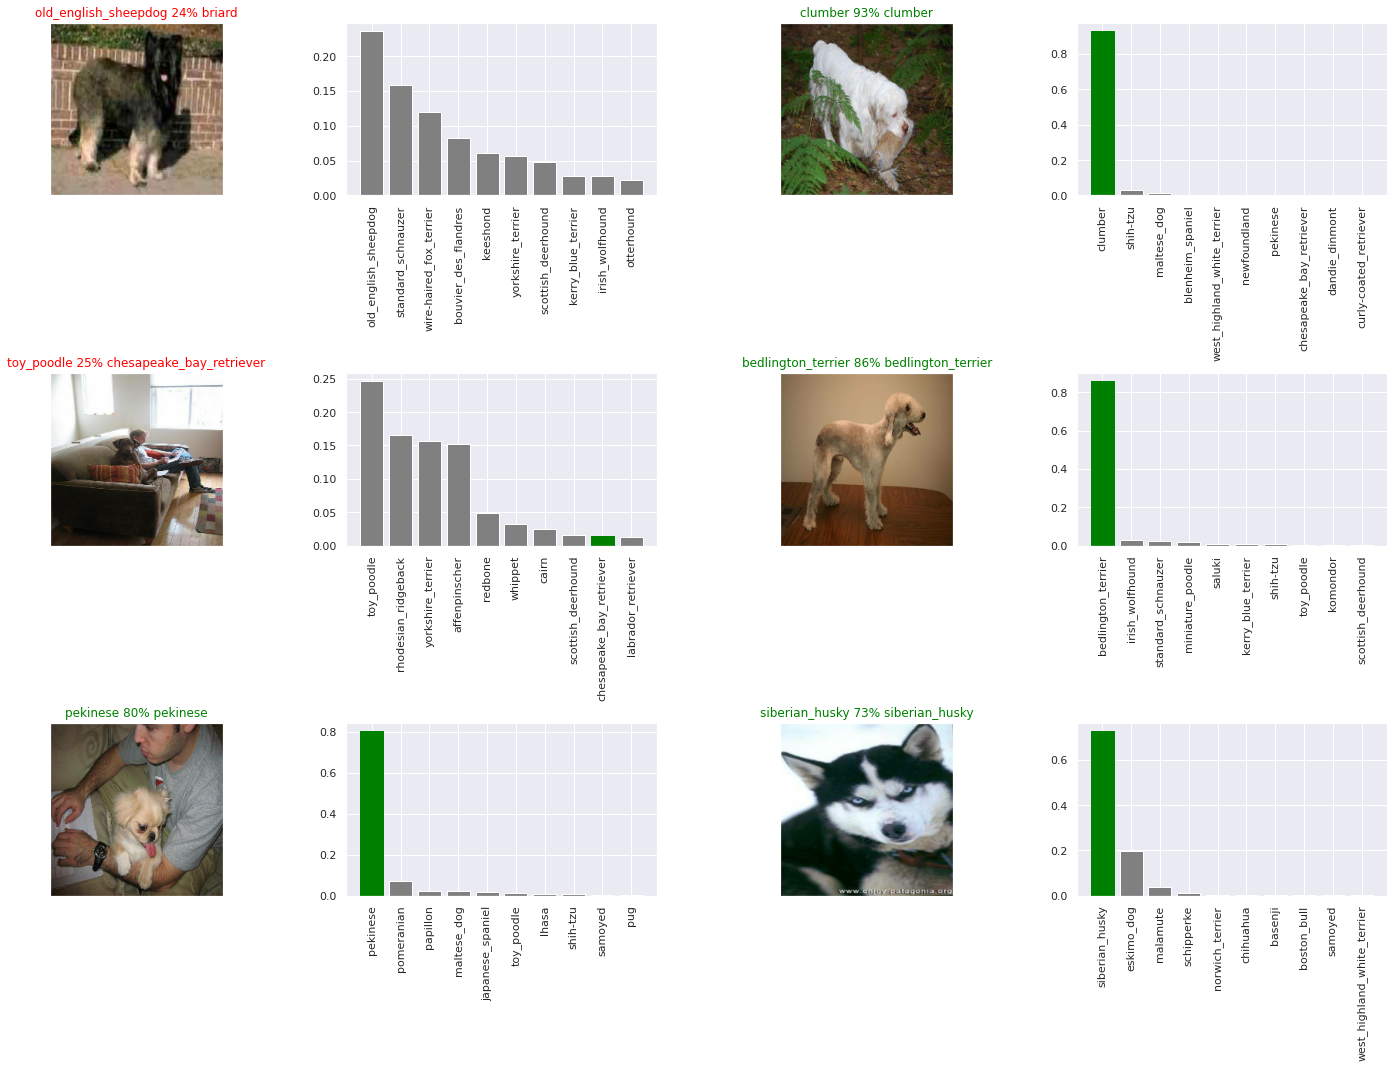

In [69]:
plot_predictions(starting_image_index=32)